# Pixel Ratio Analysis Notebook: Histogram of White Pixel Ratios by Label

**Objective:**  
Analyze the white pixel distribution in the Dot and Silhouette datasets to understand whether pixel ratio is a strong indicator of numerosity. This helps assess if the networks could be relying on low-level pixel statistics rather than abstract quantity concepts.

- Load the pre-saved Dot and Silhouette datasets from .pt files.

- Compute the white pixel ratio (number of white pixels / total pixels) for each image.

- Group pixel ratios by ground truth label (Few, Medium, Many).

- Plot histograms showing pixel ratio distributions for each label class.

**Note:**  
Make sure that the files **`train_dataset.pt`,** **`val_dataset.pt`**, **`test_dataset.pt`** and **`final_numerosity_model.pt`** are in your working directory.



# Environment Setup and Seed Setting

In [1]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42 for reproducibility.")

Random seed set to 42 for reproducibility.


# MPEG7 Dataset Generation

In [2]:
!apt-get install -y libglib2.0-0 libsm6 libxrender1 libxext6
!pip install opencv-python matplotlib -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsm6 is already the newest version (2:1.2.3-1build2).
libxext6 is already the newest version (2:1.3.4-1build1).
libxrender1 is already the newest version (1:0.9.10-1build4).
libglib2.0-0 is already the newest version (2.72.4-0ubuntu2.4).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import tarfile
import urllib.request
import cv2
import glob
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: NVIDIA L4


# Download & Extract MPEG-7 Shape Dataset

In [8]:
DATASET_URL = "https://dabi.temple.edu/external/shape/MPEG7/MPEG7dataset.zip"
ZIP_PATH = "./mpeg7.zip"
EXTRACT_DIR = "./mpeg7"
SILHOUETTE_DIR = os.path.join(EXTRACT_DIR, "original")

In [9]:
if not os.path.exists(SILHOUETTE_DIR):
    print("Downloading MPEG-7 Dataset...")
    urllib.request.urlretrieve(DATASET_URL, ZIP_PATH)

    print("Extracting...")
    import zipfile
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print("Download and extraction complete.")
else:
    print("Dataset already exists.")

Extracting...
Download and extraction complete.


# Visualize Sample Silhouettes

In [10]:
!pip install imageio -q

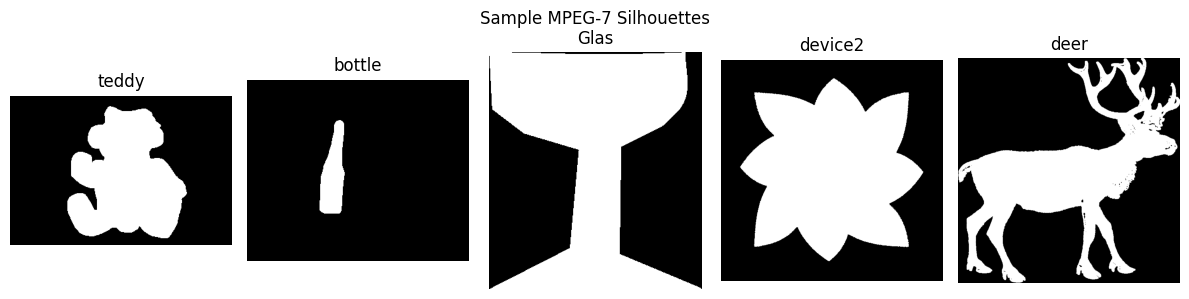

In [11]:
import imageio.v3 as iio

all_gifs = sorted(glob.glob(os.path.join(SILHOUETTE_DIR, "*.gif")))
plt.figure(figsize=(12, 3))
for i, path in enumerate(random.sample(all_gifs, 5)):
    img = iio.imread(path)[0]  # Select the first frame-
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(os.path.basename(path).split("-")[0])
    plt.axis("off")
plt.suptitle("Sample MPEG-7 Silhouettes")
plt.tight_layout()
plt.show()

# Generate Numerosity Images from Silhouettes

In [12]:
OUTPUT_DIR = "./numerosity_mpeg7"
os.makedirs(OUTPUT_DIR, exist_ok=True)

LABELS = {0: "Few", 1: "Medium", 2: "Many"}
CATEGORY_THRESHOLDS = [5, 15]  # Few: 1-5, Medium: 6-15, Many: 16-30
IMAGE_SIZE = 128
NUM_IMAGES = 3000

In [13]:
import glob
import imageio.v3 as iio

print("Loading silhouette images...")
silhouette_images = []
img_paths = glob.glob(os.path.join(SILHOUETTE_DIR, '*.gif'))
for path in img_paths:
    try:
        img = iio.imread(path)[0]
        if img is not None:
            silhouette_images.append(img)
    except Exception as e:
        print(f"Failed to read {path}: {e}")

print(f"Loaded {len(silhouette_images)} silhouettes.")

Loading silhouette images...
Loaded 1402 silhouettes.


In [14]:
# Categorize numerosity
def categorize(count):
    if count <= CATEGORY_THRESHOLDS[0]: return 0
    elif count <= CATEGORY_THRESHOLDS[1]: return 1
    else: return 2

# Composite image generator
def generate_composite():
    canvas = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)
    num_shapes = random.randint(1, 30)

    shape = random.choice(silhouette_images)
    if len(shape.shape) > 2:
        shape = cv2.cvtColor(shape, cv2.COLOR_BGR2GRAY)

    shape = cv2.resize(shape, (random.randint(20, 40), random.randint(20, 40)))
    h, w = shape.shape

    for _ in range(num_shapes):
        x = random.randint(0, IMAGE_SIZE - w)
        y = random.randint(0, IMAGE_SIZE - h)
        roi = canvas[y:y+h, x:x+w]
        canvas[y:y+h, x:x+w] = np.maximum(roi, (shape > 127).astype(np.uint8) * 255)

    return canvas, categorize(num_shapes)
# Generate and save images
print("Generating dataset...")
for i in tqdm(range(NUM_IMAGES)):
    img, label = generate_composite()
    save_path = os.path.join(OUTPUT_DIR, f"img_{i:04d}_label_{label}.png")
    cv2.imwrite(save_path, img)
print("Numerosity dataset generation complete!")

Generating dataset...


100%|██████████| 3000/3000 [00:01<00:00, 2616.30it/s]

Numerosity dataset generation complete!


# Visualize samples

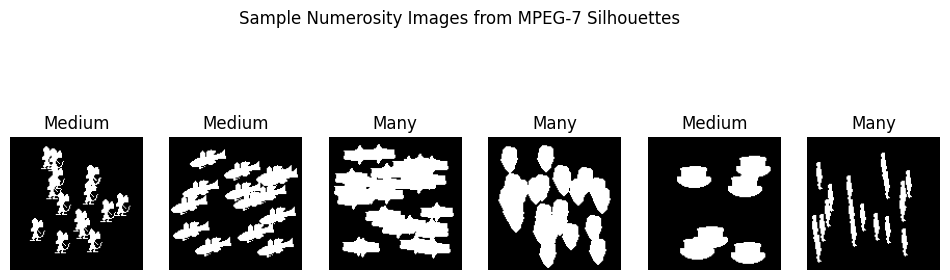

In [15]:
samples = random.sample(glob.glob(os.path.join(OUTPUT_DIR, '*.png')), 6)
plt.figure(figsize=(12, 4))
for i, path in enumerate(samples):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    label = LABELS[int(path.split('_')[-1].split('.')[0])]
    plt.subplot(1, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Numerosity Images from MPEG-7 Silhouettes")
plt.show()

# Prepare Dataset for Model

In [16]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, random_split
from PIL import Image
import os

# Step 1: Define a custom dataset
class NumerositySilhouetteDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("L")
        label = int(path.split("_")[-1].split(".")[0])
        if self.transform:
            img = self.transform(img)
        return img, label

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),               # Converts to [C x H x W], with range [0,1]
    transforms.Normalize((0.5,), (0.5,)) # Normalize grayscale to [-1, 1]
])

In [18]:
dataset = NumerositySilhouetteDataset(OUTPUT_DIR, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [19]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(val_dataset, "val_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

print(f"Saved: {len(train_dataset)} train / {len(val_dataset)} val / {len(test_dataset)} test")

Saved: 2100 train / 450 val / 450 test


In [20]:
import warnings
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

from torch.utils.data.dataset import Subset
import torch.serialization

torch.serialization.add_safe_globals([Subset])

# Load the saved datasets (train, validation, test)
train_dataset = torch.load("train_dataset.pt", weights_only=False)
val_dataset = torch.load("val_dataset.pt", weights_only=False)
test_dataset = torch.load("test_dataset.pt", weights_only=False)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 32  # default value; can be tuned later
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Dataset Size: 2100
Validation Dataset Size: 450
Test Dataset Size: 450


# Histogram generation

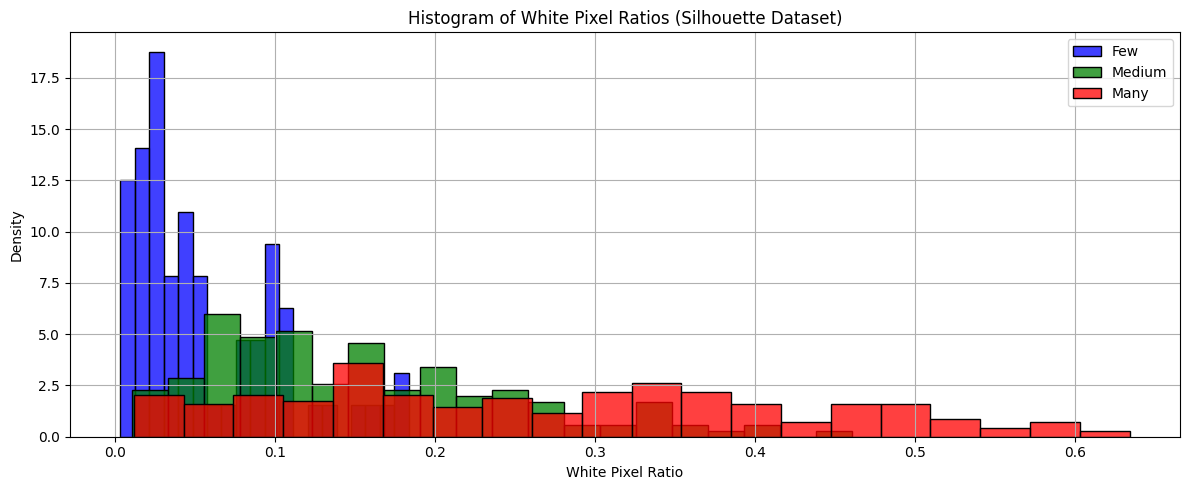

In [22]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the test dataset
test_dataset = torch.load("test_dataset.pt", weights_only=False)

# Initialize lists for each label group
ratios_few = []
ratios_medium = []
ratios_many = []

# Compute white pixel ratio for each image
for img, label in test_dataset:
    img_np = img.squeeze().numpy()  # convert tensor to 2D numpy array
    white_ratio = np.sum(img_np > 0.5) / img_np.size  # thresholding to handle float values
    if label == 0:
        ratios_few.append(white_ratio)
    elif label == 1:
        ratios_medium.append(white_ratio)
    elif label == 2:
        ratios_many.append(white_ratio)

# Plotting histograms
plt.figure(figsize=(12, 5))
sns.histplot(ratios_few, bins=20, kde=False, color='blue', label='Few', stat="density")
sns.histplot(ratios_medium, bins=20, kde=False, color='green', label='Medium', stat="density")
sns.histplot(ratios_many, bins=20, kde=False, color='red', label='Many', stat="density")

plt.title("Histogram of White Pixel Ratios (Silhouette Dataset)")
plt.xlabel("White Pixel Ratio")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()